## ARIMA model - AutoRegressive Integrated Moving Average model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load Jersey City Area Price
df = pd.read_csv('../pre_data/JerseyCity_price.csv')

In [3]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [4]:
data.head()

,price
date,
2010-11-01,1787.0
2010-12-01,1812.0
2011-01-01,1822.0
2011-02-01,1827.0
2011-03-01,1846.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


In [6]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-1.1324933255743062, 0.7019415749167719, 8, 90, {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}, 597.9698042631078)


In [7]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-3.844063303723185, 0.0024873320018663314, 7, 90, {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}, 590.0828910745347)


In [8]:
# diff_2 = diff_1.diff(1)
# diff_2 = diff_2.dropna()
# diff_2.columns = ['price_integrated']
# print(ADF(diff_2['price_integrated']))

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_1, lags=1)
print(noiseRes)

(array([68.34904046]), array([1.36971879e-16]))


In [10]:
# Select the best AR(p) and MA(q)
from statsmodels.tsa.arima_model import ARMA

def proper_model(data, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data, order=(p, q), freq='MS')
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_p, init_q

In [11]:
p,q = proper_model(data, 10)

/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInv

In [12]:
print(p,q)

9 4


In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA(9,1,4) model
model = ARIMA(data, (p,1,q), freq='MS')
arima_result = model.fit()

In [14]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 735.0146  
Dependent Variable: D.price          Log-Likelihood:      -333.12   
Date:               2019-03-27 23:01 Scale:               1.0000    
No. Observations:   98               Method:              css-mle   
Df Model:           14               Sample:              12-01-2010
Df Residuals:       84                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 6.846     
No. Iterations:     113.0000         HQIC:                711.924   
AIC:                696.2400                                        
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            4.0864    1.4529    2.8125  0.0061   1.2387   6.9340
ar.L1.D.price    0.8773    0.1417    6.1905  0.0000   0.5996   1.1551
ar.L2.D.price    0.4583    0.2105    2.1772  0.0323   0.0457   0.8709
ar.L3.D.price   -0.6073    0.1577   -3.8512  0.0002  -0.9164  -0.2982
ar.L4.D.price    0.3851    0.1805    2.1337  0.0358   0.0314   0.7388
ar.L5.D.price   -0.4355    0.1823   -2.3895  0.0191  -0.7927  -0.0783
ar.L6.D.price    0.1237    0.1676    0.7383  0.4624  -0.2047   0.4522
ar.L7.D.price    0.3239    0.1558    2.0784  0.0407   0.0185   0.6293
ar.L8.D.price   -0.2969    0.1599   -1.8569  0.0668  -0.6102   0.0165
ar.L9.D.price    0.1130    0.1147    0.9847  0.3276  -0.1119   0.3378
ma.L1.D.price    0.6724    0.1092    6.1596  0.0000   0.4584   0.8863
ma.L2.D.price    0.0217    0.0784    0.2765  0.7828  -0.1320   0.1754
ma.L3.D.price   -0.7851    0.0680  -11.5503  0.0000  -0.9184  -0.6519
ma.L4.D.price   -0.9086    0.1076   -8.4436  0.0000  -1.1195  -0.6977
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.0927            -0.1971           1.1103            -0.4716
AR.2           -1.0927             0.1971           1.1103             0.4716
AR.3           -0.2852            -1.1660           1.2004            -0.2882
AR.4           -0.2852             1.1660           1.2004             0.2882
AR.5            1.0554            -0.0000           1.0554            -0.0000
AR.6            1.1170            -0.6086           1.2720            -0.0794
AR.7            1.1170             0.6086           1.2720             0.0794
AR.8            1.0471            -1.3497           1.7082            -0.1450
AR.9            1.0471             1.3497           1.7082             0.1450
MA.1            1.0001            -0.0000           1.0001            -0.0000
MA.2           -0.3818            -0.9242           1.0000            -0.3124
MA.3           -0.3818             0.9242           1.0000             0.3124
MA.4           -1.1005            -0.0000           1.1005            -0.5000
====================================================================

"""

In [15]:
# Get forecast 6 steps ahead in future
pred = arima_result.forecast(steps=6)

In [16]:
time = pd.date_range('20190201', periods=6, freq='MS')

In [17]:
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])

In [18]:
output = pd.concat([data, pred_df], axis=0)

In [19]:
output = output.reset_index()

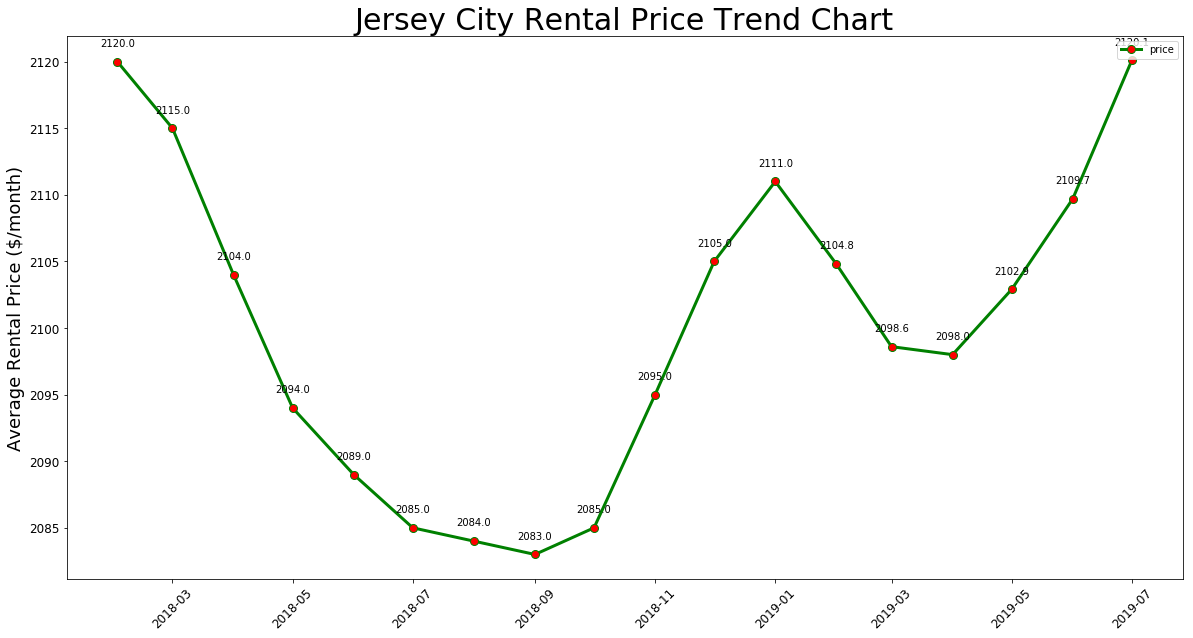

In [20]:
x = output['index'].tail(18)
y = output['price'].tail(18)

plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, color='green', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Jersey City Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 1, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.savefig("../area_predict_pics/JerseyCity.jpg")
plt.show()

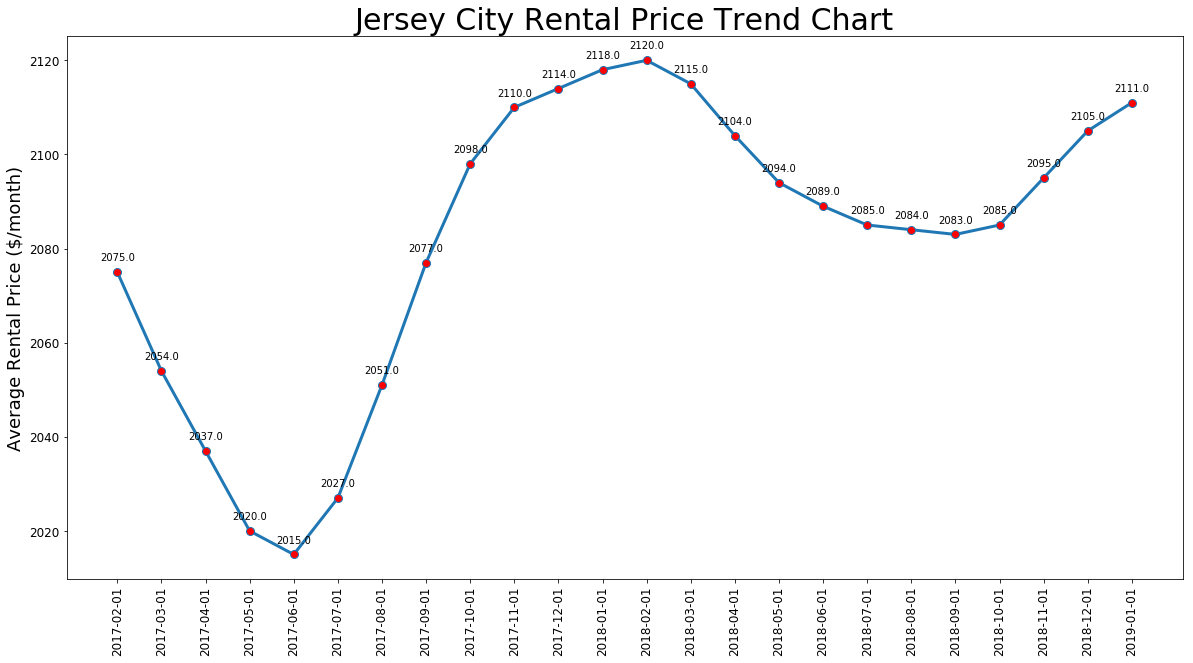

In [21]:
m = df['date'].tail(24)
n = df['price'].tail(24)
plt.figure(figsize = (20, 10))
plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
plt.title('Jersey City Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 90)
for i, j in zip(m, n):
    plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()